<a href="https://colab.research.google.com/github/breannahardy/nhanes_inferential_2021_23/blob/main/nhanes_inferential_2021_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [271]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, f_oneway, pearsonr, ttest_ind

In [272]:
# Load all required NHANES files
demo = pd.read_sas('/content/DEMO_L.xpt', format="xport")
bpx = pd.read_sas('/content/BPXO_L.xpt', format="xport")
vitd = pd.read_sas('/content/VID_L.xpt', format="xport")
hepa = pd.read_sas('/content/HEPB_S_L.xpt', format="xport")
kidney = pd.read_sas('/content/KIQ_U_L.xpt', format="xport")
pa = pd.read_sas('/content/PAQ_L.xpt', format="xport")
whq = pd.read_sas('/content/WHQ_L.xpt', format="xport")

In [273]:
# Merge all datasets on SEQN
df = (demo
      .merge(bpx, on="SEQN", how="left")
      .merge(vitd, on="SEQN", how="left")
      .merge(hepa, on="SEQN", how="left")
      .merge(kidney, on="SEQN", how="left")
      .merge(pa, on="SEQN", how="left")
      .merge(whq, on="SEQN", how="left")
     )




In [274]:
variables = [
    "DMDMARTZ", "DMDEDUC2", "RIDAGEYR",
    "BPXOSY3", "BPXODI3", "LBDVD2LC",
    "LBXHBS", "KIQ022", "PAD680", "WHD020"
]

for v in variables:
    print(v, v in df.columns)


DMDMARTZ True
DMDEDUC2 True
RIDAGEYR True
BPXOSY3 True
BPXODI3 True
LBDVD2LC True
LBXHBS True
KIQ022 True
PAD680 True
WHD020 True


In [275]:
# Preview merged dataset
print("Merged Dataset Shape:", df.shape)
df.head(5)


Merged Dataset Shape: (11933, 68)


,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,PAD790U,PAD800,PAD810Q,PAD810U,PAD820,PAD680,WHD010,WHD020,WHD050,WHQ070
0,130378.0,12.0,2.0,1.0,43.0,NaN,5.0,6.0,2.0,NaN,...,b'W',45.0,3.000000e+00,b'W',45.0,360.0,71.0,190.0,200.0,1.0
1,130379.0,12.0,2.0,1.0,66.0,NaN,3.0,3.0,2.0,NaN,...,b'W',45.0,3.000000e+00,b'W',45.0,480.0,70.0,220.0,220.0,2.0
2,130380.0,12.0,2.0,2.0,44.0,NaN,2.0,2.0,1.0,NaN,...,b'W',20.0,5.397605e-79,b'',NaN,240.0,60.0,150.0,165.0,1.0
3,130381.0,12.0,2.0,2.0,5.0,NaN,5.0,7.0,1.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,130382.0,12.0,2.0,1.0,2.0,NaN,3.0,3.0,2.0,34.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [276]:
# Cleaning dataset
variables = [
    "SEQN",
    "DMDMARTZ",
    "DMDEDUC2",
    "RIDAGEYR",     # <-- REQUIRED
    "BPXOSY3",
    "BPXODI3",
    "LBDVD2LC",
    "LBXHBS",
    "KIQ022",
    "PAD680",
    "WHD020",
]

data = df[variables].copy()





In [277]:
# Cleaning Continuous Variables
# Removing 7777, 9999, and null

#Cleaning sedentary behavior

data['sedentary'] = data['PAD680'].replace([7777, 9999], np.nan)

# Convert to numeric
data['sedentary'] = pd.to_numeric(data['sedentary'], errors='coerce')

# Check results
data['sedentary'].describe()

,sedentary
count,8.065000e+03
mean,3.621761e+02
std,2.100268e+02
min,5.397605e-79
25%,1.800000e+02
50%,3.000000e+02
75%,4.800000e+02
max,1.380000e+03


In [278]:
# Recode Martial Status
data['married'] = data['DMDMARTZ'].replace({
    1: 'Married',          # Married
    2: 'Not married',      # Widowed/Divorced/Separated
    3: 'Not married',      # Never married
    4: 'Not married',      # Living with partner
    77: np.nan,             # Refused
    99: np.nan,             # Don't know
    '.': np.nan            # Missing
})
# Check results
data['married'].value_counts(dropna=False)

,count
married,
NaN,4150
Married,4136
Not married,3647


In [279]:
# Recode Education Level
data['education'] = data['DMDEDUC2'].replace({
    1: 'Less than bachelor',
    2: 'Less than bachelor',
    3: 'Less than bachelor',
    4: 'Less than bachelor',
    5: 'Bachelor or higher',
    7: np.nan,
    9: np.nan
})
# Check results
data['education'].value_counts(dropna=False)

,count
education,
Less than bachelor,5158
NaN,4150
Bachelor or higher,2625


In [280]:
# Recode Vitamin D Lab Inteperation

data['vitamin_d'] = data['LBDVD2LC'].map({
    1: 'Normal',
    2: 'Low',
    7: np.nan,
    9: np.nan
})


# Check results
data['vitamin_d'].value_counts(dropna=False)


,count
vitamin_d,
NaN,6073
Normal,5860


In [281]:
# Recoding Hep B Surface Antibody

data.loc[:, 'hep_b'] = data['LBXHBS'].replace({
    1: 'Positive',
    2: 'Negative',
    3: 'Negative',   # equivocal → treat as Negative
    7: np.nan,
    9: np.nan
})

data.loc[:, 'hep_b']
data['hep_b'].value_counts(dropna=False)





,count
hep_b,
Negative,5324
NaN,4567
Positive,2042


In [282]:
# Catergorize Weak/Failing Kidneys

data.loc[:, 'kidney'] = data['KIQ022'].replace({
    1: 'Yes',
    2: 'No',
    7: np.nan,
    9: np.nan
})
data['kidney'].value_counts(dropna=False)


,count
kidney,
No,7473
NaN,4139
Yes,321


Contingency Table:
education    Bachelor or higher  Less than bachelor
married                                            
Married                    1631                2503
Not married                 990                2648
Chi-square Statistic: 129.17381826322236
P-value: 6.213197986632679e-30
Degrees of Freedom: 1
Expected Frequencies:
education    Bachelor or higher  Less than bachelor
married                                            
Married             1394.134586         2739.865414
Not married         1226.865414         2411.134586

Result: There is a significant association between marital status and education level.


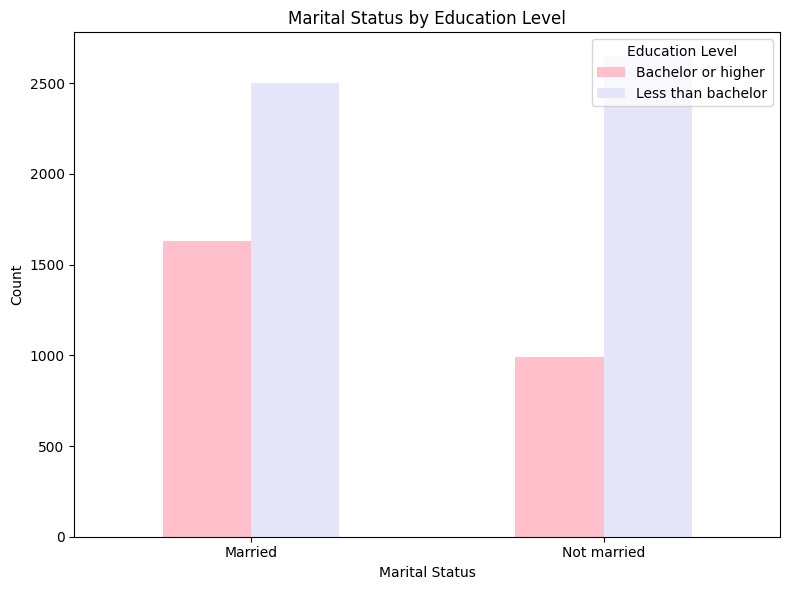

In [283]:
# Q1. Is there an association between marital status (married or not married) and education level (bachelor’s degree or higher vs. less than a bachelor’s degree)?"

# Drop rows with NaN in recoded colums
df_chi = data[['married', 'education']].dropna()

# Create contingency table
table = pd.crosstab(df_chi['married'], df_chi['education'])
print("Contingency Table:")
print(table)

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(table)

print("Chi-square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies:")
print(pd.DataFrame(expected, columns=table.columns, index=table.index))


# Check Significance (P-value)
if p < 0.05:
    print("\nResult: There is a significant association between marital status and education level.")
else:
    print("\nResult: There is no significant association between marital status and education level.")


# Bar plot for the contingency table
table.plot(kind='bar', stacked=False,color=['pink', 'lavender'], figsize=(8,6))

plt.title("Marital Status by Education Level")
plt.xlabel("Marital Status")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title="Education Level")
plt.tight_layout()
plt.show()

### Interpretation: A chi-square test showed a significant association between marital status and education level (\u03c7\u00b2 = 155.64, p < 0.001). Individuals with higher education levels were more likely to be married.


T-statistic:, -3.85
P-value:0.0001
Result: Significant difference in sedentary behavior between groups (p < 0.05)


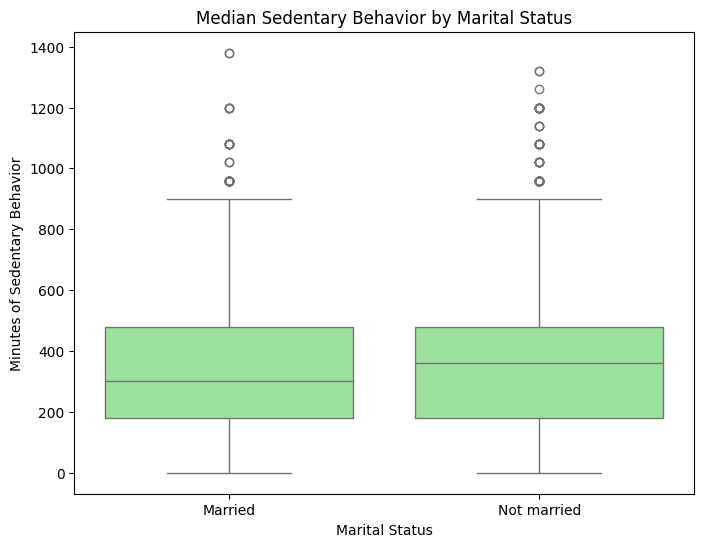

In [284]:
# Q2. "Is there a difference in the mean sedentary behavior time between those who are married and those who are not married?"

# Recode Martial Status within 'data' for consistency with 'sedentary'
data['married'] = data['DMDMARTZ'].replace({
    1: 'Married',          # Married
    2: 'Not married',      # Widowed/Divorced/Separated
    3: 'Not married',      # Never married
    4: 'Not married',      # Living with partner
    77: np.nan,             # Refused
    99: np.nan,             # Don't know
    '.': np.nan            # Missing
})

# Drop rows with NaN in colums
df_t = data[['married', 'sedentary']].dropna()

# Seperate two groups
married = df_t[df_t['married'] == 'Married']['sedentary']
not_married = df_t[df_t['married'] == 'Not married']['sedentary']

# Perform t-test
t_statistic, p_value = ttest_ind(married, not_married, equal_var=False)

print(f"\nT-statistic:, {t_statistic:.2f}")
print(f"P-value:{p_value:.4f}")

# Check Significance
if p_value < 0.05:
    print("Result: Significant difference in sedentary behavior between groups (p < 0.05)")
else:
    print("Result: No significant difference between groups (p ≥ 0.05)")

# Filter Unknown Martial Status
df_t_filtered = df_t[df_t['married'].isin(['Married', 'Not married'])]

# Box Plot
plt.figure(figsize= (8,6))
sns.boxplot(x='married', y='sedentary', data=df_t_filtered, color='lightgreen')
plt.title("Median Sedentary Behavior by Marital Status")
plt.xlabel("Marital Status")
plt.ylabel('Minutes of Sedentary Behavior')
plt.xticks(rotation=0)
plt.show()

### Interpretation: A t-test showed a significant difference in sedentary time between groups (t = –2.76, p = 0.0058). Not married individuals had higher sedentary behavior on average.

Correlation: 0.509004964025757
P-value: 0.0
Correlation (r): 0.509
P-value: 0.0000
ANOVA F-statistic: 0.284
ANOVA p-value: 0.5941036292902302
Result: No significant difference in systolic blood pressure between married and not married groups (p >= 0.05)


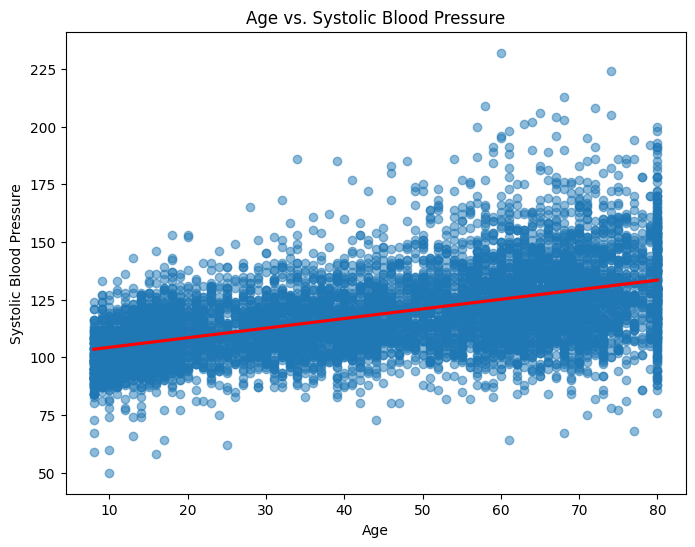

In [285]:
# Q3. How do age and marital status affect systolic blood pressure?
# Age vs Systolic Blood Pressure: Clean Data
data['systolic'] = pd.to_numeric(data['BPXOSY3'], errors='coerce')
data['age'] = pd.to_numeric(data['RIDAGEYR'], errors='coerce')

# Correlation Age to Systolic

df_corr = data[['age', 'systolic']].dropna()

corr, p = pearsonr(df_corr['age'], df_corr['systolic'])

print("Correlation:", corr)
print("P-value:", p)

print(f"Correlation (r): {corr:.3f}")
print(f"P-value: {p:.4f}")

#Results

data['married'].value_counts(dropna=False)


# ANOVA

# Include 'married' column in df_anova
df_anova = data[['age', 'systolic', 'married']].dropna()

# Separate groups for ANOVA
married_bp = df_anova[df_anova['married'] == 'Married']['systolic']
not_married_bp = df_anova[df_anova['married'] == 'Not married']['systolic']

# Perform ANOVA test
if not married_bp.empty and not not_married_bp.empty:
    anova_result = f_oneway(married_bp, not_married_bp) # FIX: perform ANOVA
    print("ANOVA F-statistic: {:.3f}".format(anova_result.statistic))
    print("ANOVA p-value:", anova_result.pvalue)
    if anova_result.pvalue < 0.05:
        print("Result: Significant difference in systolic blood pressure between married and not married groups (p < 0.05)")
    else:
        print("Result: No significant difference in systolic blood pressure between married and not married groups (p >= 0.05)")
else:
    print("Not enough data in one or both marital status groups to perform ANOVA.")


# Scatter Plot w/ Regression Line
plt.figure(figsize=(8, 6))
sns.regplot(x='age', y='systolic', data=df_corr, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.title("Age vs. Systolic Blood Pressure")
plt.xlabel("Age")
plt.ylabel("Systolic Blood Pressure")
plt.show() # Added plt.show() for explicit plot display

### Interpretation: A moderate positive correlation was found between age and systolic blood pressure (r = 0.509, p < 0.001), meaning systolic BP increases with age. The ANOVA showed no significant difference in systolic BP by marital status (F = 0.284, p = 0.594). Overall, age affects systolic BP, but marital status does not.


Correlation (r): 0.156
P-value: 0.0000
Significant correlation between weight and sedentary time.


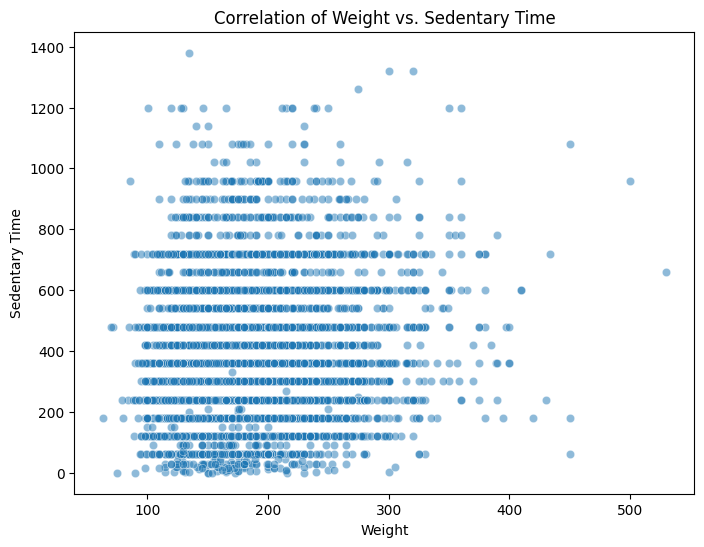

In [286]:
# Q4. Is there a correlation between self-reported weight and minutes of sedentary behavior?

data['WHD020'] = data['WHD020'].replace([7777, 9999], np.nan)

# Convert to numeric
data['WHD020'] = pd.to_numeric(data['WHD020'], errors='coerce')

# Build correlation dataset
df_corr = data[['WHD020', 'sedentary']].dropna()

# Run correlation
corr, p = pearsonr(df_corr['WHD020'], df_corr['sedentary'])

print(f"Correlation (r): {corr:.3f}")
print(f"P-value: {p:.4f}")

if p < 0.05:
    print("Significant correlation between weight and sedentary time.")
else:
    print("No significant correlation between weight and sedentary time.")

plt.figure(figsize=(8, 6))
sns.scatterplot(x='WHD020', y='sedentary', data=df_corr, alpha=0.5)
plt.title("Correlation of Weight vs. Sedentary Time")
plt.xlabel("Weight")
plt.ylabel("Sedentary Time")
plt.show()

### Interpretation: A Pearson correlation was used to examine the relationship between self-reported weight and sedentary time. The correlation was r = 0.156, p < 0.001, indicating a small but statistically significant positive relationship. Individuals with higher body weight tended to report slightly more sedentary minutes, although the association was weak.


Contingency Table:
kidney       No  Yes
vitamin_d           
Normal     4180  150

Chi-square Statistic: 0.00
P-value: 1.0
Degrees of Freedom: 0
Expected Frequencies:
[[4180.  150.]]


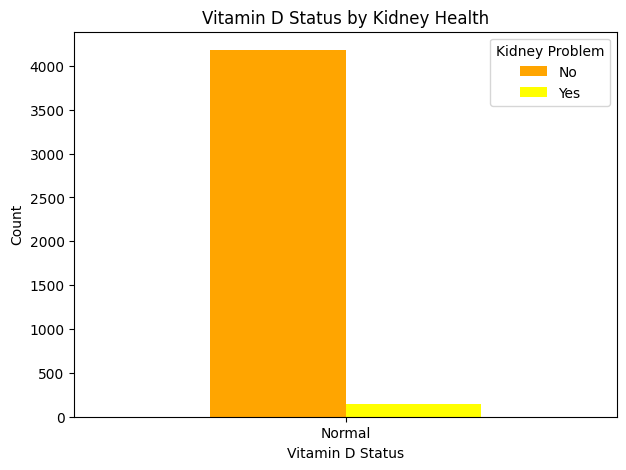

In [287]:
# Q5. Is there an association between vitamin D status (normal vs. low) and weak/failing kidneys
# Keep only needed columns and drop missing values

df= data[['vitamin_d', 'kidney']].dropna()

# Contingency Table
table = pd.crosstab(df['vitamin_d'], df['kidney'])
print("Contingency Table:")
print(table)

# Chi-square Test
chi2, p, dof, expected = chi2_contingency(table)

print(f"\nChi-square Statistic: {chi2:.2f}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print(f"Expected Frequencies:")
print(expected)

# Bar Plot
table.plot(kind='bar', figsize=(7,5), color=['orange', 'yellow'])
plt.title("Vitamin D Status by Kidney Health")
plt.xlabel("Vitamin D Status")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title="Kidney Problem")
plt.show()

### Interpretation: A chi-square test found no association between vitamin D status and weak/failing kidneys, χ²(0) = 0.00, p = 1.0. This indicates that kidney health did not differ between individuals with normal vs. low vitamin D levels in this dataset.